In [1]:
from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets.mnist import FashionMNIST
from torch.utils.data import DataLoader

transform = Compose(
    [
        ToTensor(),
        Lambda(lambda x: (x - 0.5) * 2),
    ]
)
dataset = FashionMNIST(
    "./datasets", download=True, train=True, transform=transform
)
loader = DataLoader(dataset, batch_size=128, shuffle=True)

In [2]:
import torch
import torch.nn as nn


class AutoEncoderBlock(nn.Module):
    def __init__(
        self,
        shape,
        in_channel,
        out_channel,
        kernel_size=3,
        stride=1,
        padding=1,
        activation=None,
        normalize=True,
    ):
        super().__init__()
        self.layer_norm = nn.LayerNorm(shape)
        self.conv_1 = nn.Conv2d(in_channel, out_channel, kernel_size, stride, padding)
        self.conv_2 = nn.Conv2d(out_channel, out_channel, kernel_size, stride, padding)
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.layer_norm(x) if self.normalize else x
        out = self.conv_1(out)
        out = self.activation(out)
        out = self.conv_2(out)
        out = self.activation(out)
        return out



In [5]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        # encoder
        ## layer 1
        self.layer_1_block = nn.Sequential(
            AutoEncoderBlock(shape=(1, 28, 28), in_channel=1, out_channel=10),
            AutoEncoderBlock(shape=(10, 28, 28), in_channel=10, out_channel=10),
            AutoEncoderBlock(shape=(10, 28, 28), in_channel=10, out_channel=10),
        )
        self.layer_1_down = nn.Conv2d(10, 10, 4, 2, 1)
        ## layer 2
        self.layer_2_block = nn.Sequential(
            AutoEncoderBlock(shape=(10, 14, 14), in_channel=10, out_channel=20),
            AutoEncoderBlock(shape=(20, 14, 14), in_channel=20, out_channel=20),
            AutoEncoderBlock(shape=(20, 14, 14), in_channel=20, out_channel=20),
        )
        self.layer_2_down = nn.Conv2d(20, 20, 4, 2, 1)

        ## layer 3
        self.layer_3_block = nn.Sequential(
            AutoEncoderBlock(shape=(20, 7, 7), in_channel=20, out_channel=40),
            AutoEncoderBlock(shape=(40, 7, 7), in_channel=40, out_channel=40),
            AutoEncoderBlock(shape=(40, 7, 7), in_channel=40, out_channel=40),
        )
        self.layer_3_down = nn.Sequential(
            nn.Conv2d(40, 40, 2, 1), nn.SiLU(), nn.Conv2d(40, 40, 4, 2, 1)
        )
        # decoder
        ## layer 4
        self.layer_4_up = nn.Sequential(
            nn.ConvTranspose2d(40, 40, 4, 2, 1),
            nn.SiLU(),
            nn.ConvTranspose2d(40, 40, 2, 1),
        )

        self.layer_4_block = nn.Sequential(
            AutoEncoderBlock(shape=(80, 7, 7), in_channel=80, out_channel=40),
            AutoEncoderBlock(shape=(40, 7, 7), in_channel=40, out_channel=20),
            AutoEncoderBlock(shape=(20, 7, 7), in_channel=20, out_channel=20),
        )

        ## layer 5
        self.layer_5_up = nn.ConvTranspose2d(20, 20, 4, 2, 1)
        self.layer_5_block = nn.Sequential(
            AutoEncoderBlock(shape=(40, 14, 14), in_channel=40, out_channel=20),
            AutoEncoderBlock(shape=(20, 14, 14), in_channel=20, out_channel=10),
            AutoEncoderBlock(shape=(10, 14, 14), in_channel=10, out_channel=10),
        )

        ## layer 6
        self.layer_6_up = nn.ConvTranspose2d(10, 10, 4, 2, 1)
        self.layer_6_block = nn.Sequential(
            AutoEncoderBlock(shape=(20, 28, 28), in_channel=20, out_channel=10),
            AutoEncoderBlock(shape=(10, 28, 28), in_channel=10, out_channel=10),
            AutoEncoderBlock(
                shape=(10, 28, 28), in_channel=10, out_channel=10, normalize=False
            ),
        )

        self.conv_out = nn.Conv2d(10, 1, 3, 1, 1)

    def forward(self, x):
        # encoding
        out_1_block_result = self.layer_1_block(x)  # (N, 10, 28, 28)
        out_1_down_result = self.layer_1_down(out_1_block_result)  # (N, 10, 14, 14)
        out_2_block_result = self.layer_2_block(out_1_down_result)  # (N, 20, 14, 14)
        out_2_down_result = self.layer_2_down(out_2_block_result)  # (N, 20, 7, 7)
        out_3_block_result = self.layer_3_block(out_2_down_result)  # (N, 40, 7, 7)
        out_3_down_result = self.layer_3_down(out_3_block_result)  # (N, 40, 3, 3)

        # decoding
        out_4_up_result = self.layer_4_up(out_3_down_result)  # (N, 40, 7, 7)
        out_4_concat_down_up = torch.cat(
            (out_3_block_result, out_4_up_result), dim=1
        )  # (N, 80, 7, 7)

        out_4_block_result = self.layer_4_block(out_4_concat_down_up)  # (N, 20, 7, 7)

        out_5_up_result = self.layer_5_up(out_4_block_result)  # (N, 20, 14, 14)
        out_5_concat_down_up = torch.cat(
            (out_2_block_result, out_5_up_result), dim=1
        )  # (N, 40, 14, 14)
        out_5_block_result = self.layer_5_block(out_5_concat_down_up)  # (N, 10, 14, 14)

        out_6_up_result = self.layer_6_up(out_5_block_result)  # (N, 10, 28, 28)
        out_6_concat_down_up = torch.cat(
            (out_1_block_result, out_6_up_result), dim=1
        )  # (N, 20, 28, 28)
        out_6_block_result = self.layer_6_block(out_6_concat_down_up)  # (N, 10, 28, 28)
        out = self.conv_out(out_6_block_result)  # (N, 1, 28, 28)
        return out


In [6]:
unet = UNet()

In [7]:
for batch in loader:
    x = batch[0]
    break

with torch.no_grad():
    # encoding
    out_1_block_result = unet.layer_1_block(x)  # (N, 10, 28, 28)
    out_1_down_result = unet.layer_1_down(out_1_block_result)  # (N, 10, 14, 14)
    out_2_block_result = unet.layer_2_block(out_1_down_result)  # (N, 20, 14, 14)
    out_2_down_result = unet.layer_2_down(out_2_block_result)  # (N, 20, 7, 7)
    out_3_block_result = unet.layer_3_block(out_2_down_result)  # (N, 40, 7, 7)
    out_3_down_result = unet.layer_3_down(out_3_block_result)  # (N, 40, 3, 3)

    # decoding
    out_4_up_result = unet.layer_4_up(out_3_down_result)  # (N, 40, 7, 7)
    out_4_concat_down_up = torch.cat(
        (out_3_block_result, out_4_up_result), dim=1
    )  # (N, 80, 7, 7)

    out_4_block_result = unet.layer_4_block(out_4_concat_down_up)  # (N, 20, 7, 7)

    out_5_up_result = unet.layer_5_up(out_4_block_result)  # (N, 20, 14, 14)
    out_5_concat_down_up = torch.cat(
        (out_2_block_result, out_5_up_result), dim=1
    )  # (N, 40, 14, 14)
    out_5_block_result = unet.layer_5_block(out_5_concat_down_up)  # (N, 10, 14, 14)

    out_6_up_result = unet.layer_6_up(out_5_block_result)  # (N, 10, 28, 28)
    out_6_concat_down_up = torch.cat(
        (out_1_block_result, out_6_up_result), dim=1
    )  # (N, 20, 28, 28)
    out_6_block_result = unet.layer_6_block(out_6_concat_down_up)  # (N, 10, 28, 28)
    out = unet.conv_out(out_6_block_result)  # (N, 1, 28, 28)

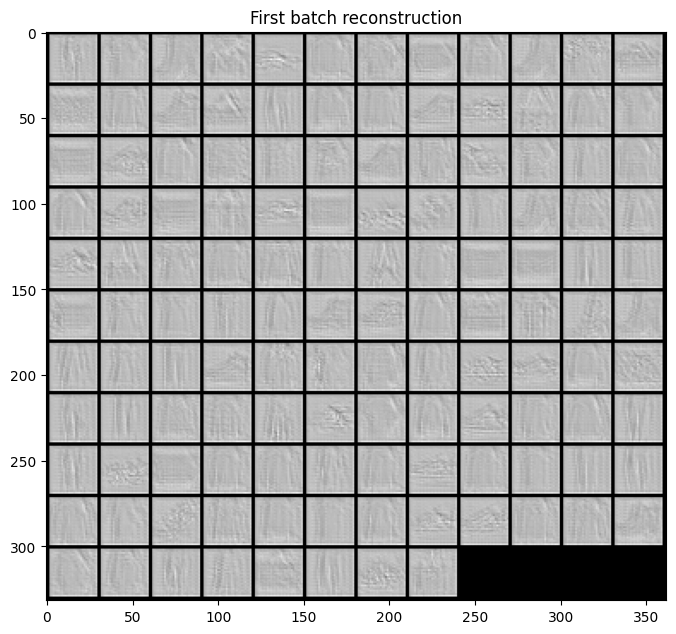

In [11]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid


out_x_grid = make_grid(out, nrow=12).numpy()

plt.figure(figsize=(8, 8))
plt.title("First batch reconstruction")
plt.imshow(out_x_grid[0], cmap="gray")

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [13]:
_ = unet.to(device)

In [15]:
import torch.optim as optim
from tqdm import tqdm

mse_fn = nn.MSELoss()
optimizer = optim.Adam(unet.parameters(), lr=0.001)
n_epochs = 10

for epoch in range(n_epochs):
    epoch_loss = 0.0
    for step, batch in enumerate(tqdm(loader, desc=f"Epoch {epoch + 1}/{n_epochs}")):
        x = batch[0].to(device)
        recon_x = unet(x)

        loss = mse_fn(x, recon_x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * len(x) / len(loader.dataset)

    log_string = f"Loss at epoch {epoch + 1}: {epoch_loss:.3f}"

    print(log_string)

Epoch 1/10: 100%|██████████| 469/469 [00:16<00:00, 29.02it/s]


Loss at epoch 1: 0.065


Epoch 2/10: 100%|██████████| 469/469 [00:13<00:00, 34.70it/s]


Loss at epoch 2: 0.009


Epoch 3/10: 100%|██████████| 469/469 [00:13<00:00, 34.31it/s]


Loss at epoch 3: 0.005


Epoch 4/10: 100%|██████████| 469/469 [00:13<00:00, 34.63it/s]


Loss at epoch 4: 0.003


Epoch 5/10: 100%|██████████| 469/469 [00:13<00:00, 33.93it/s]


Loss at epoch 5: 0.003


Epoch 6/10: 100%|██████████| 469/469 [00:13<00:00, 34.25it/s]


Loss at epoch 6: 0.002


Epoch 7/10: 100%|██████████| 469/469 [00:13<00:00, 35.09it/s]


Loss at epoch 7: 0.002


Epoch 8/10: 100%|██████████| 469/469 [00:13<00:00, 34.66it/s]


Loss at epoch 8: 0.001


Epoch 9/10: 100%|██████████| 469/469 [00:13<00:00, 34.26it/s]


Loss at epoch 9: 0.001


Epoch 10/10: 100%|██████████| 469/469 [00:14<00:00, 33.17it/s]

Loss at epoch 10: 0.001


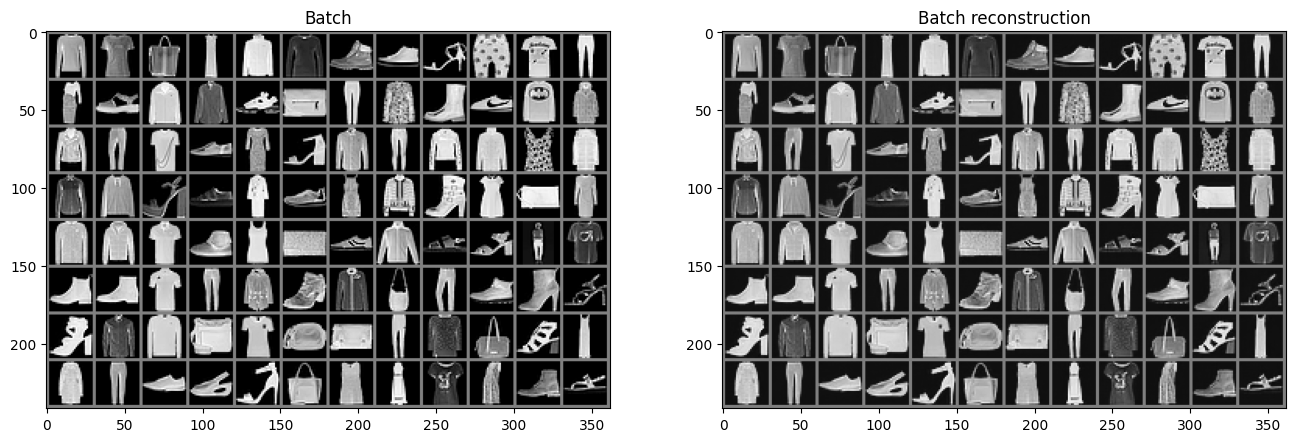

In [17]:
with torch.no_grad():    
    x = batch[0].to(device)
    recon_x = unet(x)
recon_x = recon_x.cpu()

x_grid = make_grid(x.cpu(), nrow=12).numpy()
recon_x_grid = make_grid(recon_x, nrow=12).numpy()

fig, axes = plt.subplots(ncols=2, figsize=(16, 8))

axes[0].set_title("Batch")
axes[0].imshow(x_grid[0], cmap="gray")

axes[1].set_title("Batch reconstruction")
axes[1].imshow(recon_x_grid[0], cmap="gray")